## Refining the spin direction

This notebook provides examples of two methods for refining the spin direction: 
   1. Updating the basis vector(s) and calling the makeSpins() function, which is a very general method and will work for magnetic structures of arbitrary complexity;
   2. Storing the locations of the "up" spins and "down" spins and updating them without calling makeSpins(), which is faster but best suited only for simple collinear magnetic structures.

In [1]:
### Import everything we need
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

from diffpy.mpdf import *
from diffpy.Structure import loadStructure

import time # we will be doing some speed testing

%matplotlib notebook

/home/ben/anaconda/envs/mpdfdev/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
### Create the structure from our cif file, update the lattice params
structureFile = "MnO_R-3m.cif"
mnostructure = loadStructure(structureFile)
lat = mnostructure.lattice
lat.a, lat.b, lat.c = 3.1505626, 3.1505626, 7.5936979 # refined values from PDFgui
print mnostructure

lattice=Lattice(a=3.15056, b=3.15056, c=7.5937, alpha=90, beta=90, gamma=120)
Mn   0.000000 0.000000 0.000000 1.0000
Mn   0.333333 0.666667 0.666667 1.0000
Mn   0.666667 0.333333 0.333333 1.0000
O    0.000000 0.000000 0.500000 1.0000
O    0.333333 0.666667 0.166667 1.0000
O    0.666667 0.333333 0.833333 1.0000


In [3]:
### Set up the magSpecies
mn2p=MagSpecies(struc=mnostructure, label='Mn2+')
mn2p.magIdxs = [0,1,2]
mn2p.kvecs = np.array([0,0,1.5])
mn2p.ffparamkey = 'Mn2'

# start with a randomly oriented spin basis vector
theta0 = np.arccos(np.random.uniform(-1,1))
phi0 = np.random.uniform(-np.pi,np.pi)
mn2p.basisvecs = 2.5*np.array([[np.sin(theta0)*np.cos(phi0),
                                np.sin(theta0)*np.sin(phi0), np.cos(theta0)]])

In [4]:
### Create and prep the magStructure
mstr = MagStructure()
mstr.loadSpecies(mn2p)
mstr.makeAll()

Coordinates of atoms and spins for Mn2+
have not been loaded because they have not yet been
generated and/or do not match in shape.
Running checks for Mn2+ MagSpecies object...

kvecs and basisvecs must have the same dimensions.
Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.
Running checks for Mn2+ MagSpecies object...

kvecs and basisvecs must have the same dimensions.
Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.


/home/ben/anaconda/envs/mpdfdev/lib/python2.7/site-packages/diffpy.Structure-1.3.2-py2.7.egg/diffpy/Structure/lattice.py:125: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if [a, b, c, alpha, beta, gamma, base] == 7*[None]:


In [5]:
### Set up the mPDF calculator
mc = MPDFcalculator(magstruc=mstr)

In [6]:
### Load the data
PDFfitFile = 'MnOfit_PDFgui.fgr'
rexp,Drexp = getDiffData([PDFfitFile])
mc.rmin = rexp.min()
mc.rmax = rexp.max()

### Method 1: Update the basis vector directly and call makeSpins() (slower)

Refined parameters:  [  3.75623138e+00   1.14768778e+00   1.57078652e+00  -8.42358774e+03]
Duration of refinement:  2.83608698845
Refined spin:  [ -1.39704933e+00   2.07322290e+00   2.45182236e-05]


<IPython.core.display.Javascript object>


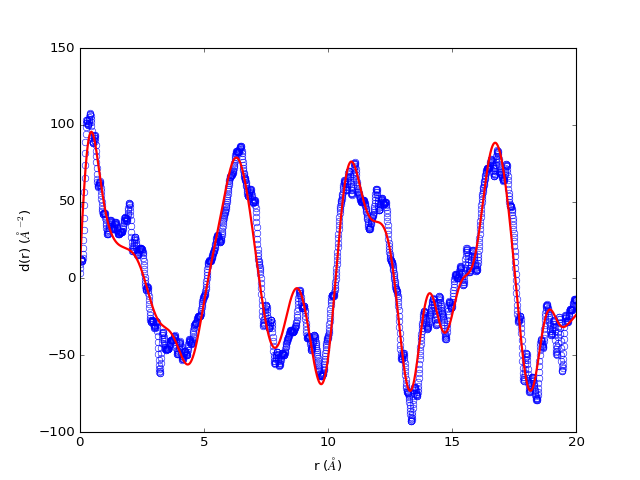

In [7]:
# Do the refinement
def residual1(p,yexp):
    mc.paraScale, mc.ordScale, theta, phi = p
    mn2p.basisvecs = 2.5*np.array([np.sin(theta)*np.cos(phi),
                                   np.sin(theta)*np.sin(phi), np.cos(theta)])
    mstr.makeSpins()
    return yexp - mc.calc(both=True)[2]

p0 = [5.0, 3.0, theta0, phi0] # initial parameter values

start = time.time()
pOpt = leastsq(residual1, p0, args=(Drexp))
end = time.time()

print 'Refined parameters: ', pOpt[0]
print 'Duration of refinement: ', end-start
thetaF, phiF = pOpt[0][2], pOpt[0][3]
Sfinal = 2.5*np.array([np.sin(thetaF)*np.cos(phiF),
                       np.sin(thetaF)*np.sin(phiF),np.cos(thetaF)])
print 'Refined spin: ', Sfinal

fit=mc.calc(both=True)[2]

# Plot the results
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(rexp,Drexp,marker='o',mfc='none',mec='b',linestyle='none')
ax.plot(rexp,fit,'r-',lw=2)
ax.set_xlim(xmin=mc.rmin,xmax=mc.rmax)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('d(r) ($\AA^{-2}$)')

plt.show()

### Method 2: Store the indices of the up and down spins and use these to update (faster)

Refined parameters:  [  3.75623138e+00   1.14768778e+00   1.57078652e+00  -8.42358774e+03]
Duration of refinement:  2.67924809456
Refined spin:  [ -1.39704933e+00   2.07322290e+00   2.45182236e-05]


<IPython.core.display.Javascript object>


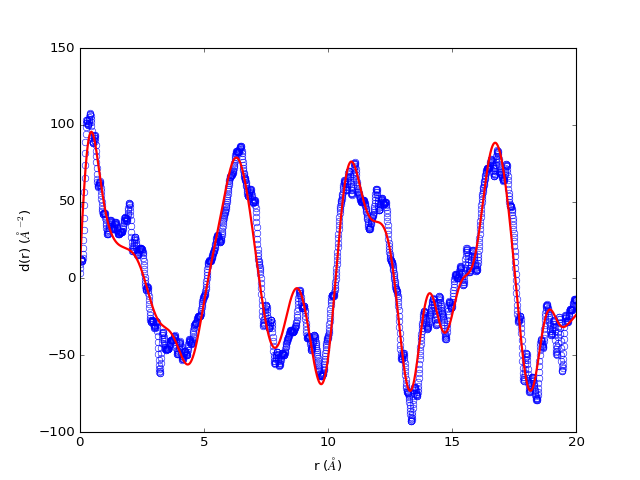

In [8]:
### Reset the magnetic structure to how it was originally
mn2p.basisvecs = 2.5*np.array([np.sin(theta0)*np.cos(phi0),
                               np.sin(theta0)*np.sin(phi0), np.cos(theta0)])
mstr.makeSpins()

### Find the locations of the up and down spins (we are creating boolean masks)
upSpins = np.all(mstr.spins==mn2p.basisvecs, axis=1)
downSpins = np.all(mstr.spins==-1.0*mn2p.basisvecs, axis=1)
# Warning! If you define your basisvecs as a nested array, i.e. np.array([[x,y,z]]),
# you will want to use basisvecs[0] instead of basisvecs in the two preceding lines.

### Modify the residual function
def residual2(p,yexp):
    mc.paraScale, mc.ordScale, theta, phi = p
    Svec = 2.5*np.array([np.sin(theta)*np.cos(phi),
                         np.sin(theta)*np.sin(phi), np.cos(theta)])
    mstr.spins[upSpins] = Svec
    mstr.spins[downSpins] = -Svec
    return yexp - mc.calc(both=True)[2]

p0=[5.0, 3.0, theta0, phi0] # initial parameter values

start = time.time()
pOpt = leastsq(residual2, p0, args=(Drexp))
end=time.time()

print 'Refined parameters: ', pOpt[0]
print 'Duration of refinement: ', end-start
thetaF, phiF = pOpt[0][2], pOpt[0][3]
Sfinal = 2.5*np.array([np.sin(thetaF)*np.cos(phiF),
                       np.sin(thetaF)*np.sin(phiF), np.cos(thetaF)])
print 'Refined spin: ', Sfinal

### Update the magnetic structure with the refined spin
#mn2p.basisvecs = np.array([Sfinal])
#mstr.makeSpins()
fit = mc.calc(both=True)[2]

### Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rexp, Drexp, marker='o', mfc='none', mec='b', linestyle='none')
ax.plot(rexp, fit, 'r-', lw=2)
ax.set_xlim(xmin=mc.rmin, xmax=mc.rmax)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('d(r) ($\AA^{-2}$)')

plt.show()

In [9]:
plt.close('all')